In [1]:
from all_functions import * 
from sklearn.decomposition import PCA
import copy
from scipy.linalg import eigh
from sklearn.linear_model import LinearRegression

In [2]:
"""
This new functions takes the following inputs: 

    name -- the name of the Y variables, should be within double quote
    ncomps -- number of principal components to be used 
    error_comps -- number of error components to be used 
    outlier_remove -- a logical variable indicating whether to remove outliers 
    
This function select the Y variable based on the input name, and set X as 
all other variables. 

"""
def FRED_MD_DATA_PREP(name, ncomps = 5, error_comps = 5, outlier_remove = False):
   
    """
    Read the entire data
    """
    
    data = pd.read_csv('Transformed_na_removed.csv')
    
    """
    Set the Y axis to be the column of given name in the input, 
    remove that column and set the rest of the matrix as X. 
    Finally, do PCA on the X matrix. 
    
    """
    
    Y_axis = name
    X = copy.deepcopy(data)
    X.pop(name)
    X = X.to_numpy()
    n_data = X.shape[0]
    Y = data[name].to_numpy()
    W, V = eigh(X @ X.T)
    F_hat = np.sqrt(n_data) * V[:,-ncomps:] # select last ncomps columns of V
    B_hat = (1/n_data) * (X.T @ F_hat)
    
    if error_comps > 0:
        
        """
        First we project out the space of principal components
        to estimate the idiosyncratic errors. 
        """
        
#         loadings = X.T @ X_pca @ np.linalg.inv(X_pca.T @ X_pca) # OLS of X on X.pca
#         errors = X - X_pca @ loadings.T # OLS residuals
        U_hat = X - (F_hat @ B_hat.T)
        model = LinearRegression()
        model.fit(F_hat, Y)
        Y_u = Y - model.predict(F_hat)
        
        
        """
            Next we apply conditional SURE independent screening to select the 
            idiosyncratic components.
        """
       
        def cor_cal(x):
            return np.corrcoef(x, Y_u)[0, 1]
        
        cor_vec = np.apply_along_axis(cor_cal, 0, U_hat)
        idx = np.argsort(-np.abs(cor_vec))
        errors_to_add = U_hat[:,idx[:error_comps]]
        Data = np.hstack([F_hat, errors_to_add, Y.reshape(-1, 1)])
    
    else:
        Data = np.hstack([F_hat, Y.reshape(-1, 1)])
    
    if outlier_remove:
        Q1 = np.percentile(Y, 25, method = 'midpoint')
        Q3 = np.percentile(Y, 75, method = 'midpoint')
        IQR = Q3 - Q1
        upper=Q3+1.5*IQR
        upper_array=np.array(Y<=upper)
        lower=Q1-1.5*IQR
        lower_array=np.array(Y>=lower)
        index_keep = upper_array & lower_array
        Data = Data[index_keep[:,0].tolist(),:]
        print("The number of data being removed is ", Y.shape[0]-Data.shape[0])
        
    return Data, Y_axis

In [3]:
def UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
    X_pre = train_data[:,:-1]
    Y_pre = train_data[:,-1].reshape(-1,1)
    X_opt = train_data[:,:-1]
    Y_opt = train_data[:,-1].reshape(-1,1)
    X_adj = train_data[:,:-1]
    Y_adj = train_data[:,-1].reshape(-1,1)
    X_t = test_data[:,:-1]
    Y_t = test_data[:,-1].reshape(-1,1)


    n_pre = len(Y_pre)
    n_opt = len(Y_opt)
    n_adj = len(Y_adj)
    n_t = len(Y_t)

    # Obtain mean estimator
    known_mean = "False"
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN1"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)

    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre,X_opt,X_adj,X_t,est_type ="NN1")


    # Obtain quantile estimators
    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
    E_t = E_t.T


    # solve optimization problem

    optimal_weight, V100_adj, V100_t= solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

    # adjust interval
    if shrink: 
        alpha = 0.05
        delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha,stepsize = 0.001)

        # plot
        V_alpha_t = delta*V100_t
    else:
        V_alpha_t = V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    print("The overall coverage for UTOPIA is", coverage)
    print("Mean bandwidth on test data for UTOPIA is", bandwidth)
    return X_t,Y_t,M_t,V_alpha_t,coverage,bandwidth

In [4]:
def LQR_FRED_MD_MULTIVARIATE(Data):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])

    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,-1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,:-1]
    Y_quantile = train_data[:,-1].reshape(-1,1)
    X_test = test_data[:,:-1]
    Y_test = test_data[:,-1].reshape(-1,1)

    # Estimate the mean using NN1
    est_type = "NN1"
    M_quantile, M_test = mean_est_others(est_type,X_lin,Y_lin,X_quantile,X_test)

    # Estimate the quantile
    alpha = 0.05

    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0, solver = 'highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for LQR is", coverage)
    print("Mean bandwidth on test data for LQR is", bandwidth)
    return X_test,Y_test,M_test,V_test, coverage, bandwidth

In [5]:
def SplitCF_FRED_MD_MULTIVARIATE(Data): 
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])


    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_res = train_data[:,:-1]
    Y_res = train_data[:,1].reshape(-1,1)
    y_res = Y_res[:,0]
    X_test = test_data[:,:-1]
    Y_test = test_data[:,1].reshape(-1,1)
    y_test = Y_test[:,0]

    # Estimate the mean using NN1
    est_type = "NN1"
    Y_res_pred, M_test = mean_est_others(est_type,X_lin,Y_lin,X_res,X_test)
    y_res_pred = Y_res_pred[:,0]

    # Calculate the conformity scores
    residuals = np.abs(y_res - y_res_pred)

    alpha = 0.05  # 95% confidence level
    k = int((1 - alpha) * len(y_lin))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    # Calculate the prediction interval
    v_test = (threshold**2)*np.ones(len(y_test))
    V_test = v_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for SplitCF is", coverage)
    print("Mean bandwidth on test data for SplitCF is", bandwidth)
    return X_test,Y_test,M_test,V_test,coverage,bandwidth

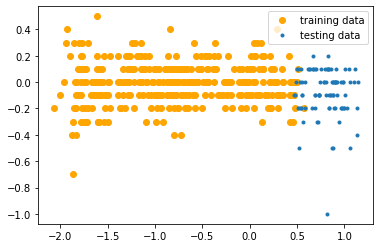

In [6]:
Data, Y_axis = FRED_MD_DATA_PREP('UNRATE')
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])
plt.plot(train_data[:,2],train_data[:,-1],'o',color = 'orange',label = 'training data')
plt.plot(test_data[:,2],test_data[:,-1],'.', label = 'testing data')
plt.legend(loc="upper right")
plt.show()

In [7]:

Data, Y_axis = FRED_MD_DATA_PREP('UNRATE', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.07003996331154592
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.019481736196401932
The overall coverage for SplitCF is 0.5824175824175825
Mean bandwidth on test data for SplitCF is 0.00032963343301290485


In [8]:

Data, Y_axis = FRED_MD_DATA_PREP('HOUST', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 8.066893792530138
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 2.3525676079742994
The overall coverage for SplitCF is 0.25274725274725274
Mean bandwidth on test data for SplitCF is 0.011559185473027074


In [13]:

Data, Y_axis = FRED_MD_DATA_PREP('FEDFUNDS', ncomps=2, error_comps=2)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.021827271086752226
The overall coverage for LQR is 0.5164835164835165
Mean bandwidth on test data for LQR is 0.004022566595884714
The overall coverage for SplitCF is 0.7252747252747253
Mean bandwidth on test data for SplitCF is 0.00522413371357658


In [10]:
Data, Y_axis = FRED_MD_DATA_PREP('INVEST', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0018242354626240589
The overall coverage for LQR is 0.9560439560439561
Mean bandwidth on test data for LQR is 0.001061662926396504
The overall coverage for SplitCF is 0.23076923076923078
Mean bandwidth on test data for SplitCF is 0.010660087145819206


In [11]:
Data, Y_axis = FRED_MD_DATA_PREP('REALLN', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0004913250561160671
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.0005568849521023783
The overall coverage for SplitCF is 0.25274725274725274
Mean bandwidth on test data for SplitCF is 0.010971038448459643


In [20]:
Data, Y_axis = FRED_MD_DATA_PREP('DTCOLNVHFNM', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0018527897096183518
The overall coverage for LQR is 0.978021978021978
Mean bandwidth on test data for LQR is 0.003254853938659995
The overall coverage for SplitCF is 0.34065934065934067
Mean bandwidth on test data for SplitCF is 0.011295149821953858
